In [1]:
import os
import sys
import time
import copy
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import sklearn.datasets

import matplotlib.pyplot as plt

## Load MNIST

In [2]:
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home='mnist_784')

In [3]:
x_train = torch.tensor(mnist.data[:60000].values, dtype=torch.float) / 255.
y_train = torch.tensor([int(x) for x in mnist.target[:60000]])
x_test = torch.tensor(mnist.data[60000:].values, dtype=torch.float) / 255.
y_test = torch.tensor([int(x) for x in mnist.target[60000:]])

In [4]:
x_train.shape, x_train[0].shape

(torch.Size([60000, 784]), torch.Size([784]))

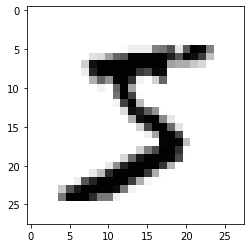

In [5]:
plt.imshow(1 - x_train[0].reshape((28, 28)), cmap="gray", vmin=0, vmax=1)

## Define Custom Dataset

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        image = self.images[index].reshape((1, 28, 28))
        return image, self.labels[index]

    def __len__(self):
        return len(self.images)

## Define Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # (28, 28, 32)
        self.relu_1 = nn.ReLU()
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # (14, 14, 32)

        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # (14, 14, 64)
        self.relu_2 = nn.ReLU()
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (7, 7, 64)

        self.fc_1 = nn.Linear(7 * 7 * 64, 10)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.pool_2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)

        return x

## Hyper-paremeters

In [8]:
learning_rate = 1e-3
batch_size = 100
num_epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Make Dataset, DataLoader

In [9]:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

In [10]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [11]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

## Training

In [12]:
for epoch in range(num_epochs):
    correct_count = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        correct_count += torch.sum(preds == labels)

    print(f'[Epoch {epoch+1}/{num_epochs}] acc: {correct_count.double() / len(train_loader):.3f}')

[Epoch 1/5] acc: 93.923
[Epoch 2/5] acc: 98.130
[Epoch 3/5] acc: 98.528
[Epoch 4/5] acc: 98.858
[Epoch 5/5] acc: 99.075


## Test

In [13]:
correct_count = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)

        correct_count += torch.sum(preds == labels)

print(f"Accuracy: {correct_count.double() / len(test_loader):.3f}%")

Accuracy: 98.700%
